In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm

import dateutil.parser

## Preprocessing and feature engineering

__feature engineering for prediction was done after I looked at the data, but I put it here to order the flow of the notebook better__

In [2]:
df = pd.read_json('datascience_assignment_data.json')

In [3]:
df.head()

distance  preorder               timestamp                           tz  \
0  3.123568     False 2018-04-10 09:36:53.754  {'zone': 'Europe/Helsinki'}   
1  2.489746     False 2018-04-10 10:27:39.279  {'zone': 'Europe/Helsinki'}   
2  1.378161     False 2018-04-10 10:35:22.101  {'zone': 'Europe/Helsinki'}   
3  2.390313     False 2018-04-10 12:32:17.173  {'zone': 'Europe/Helsinki'}   
4  2.493781     False 2018-04-10 13:13:56.298  {'zone': 'Europe/Helsinki'}   

                   venue_tags weather  
0  [sushi, japanese, gourmet]   sunny  
1               [sushi, fish]   sunny  
2  [sushi, japanese, gourmet]   sunny  
3               [sushi, fish]   sunny  
4  [sushi, japanese, gourmet]   sunny

__distance is dropped because it is not used in data exploration__

In [4]:
df = df.drop(['distance'], axis=1)

__preorder is always false so we can drop it from consideration__

In [5]:
df['preorder'].unique()

array([False])

In [6]:
df = df.drop(['preorder'], axis=1)

__timezone is always constant Europe/Helsinki so we can drop it from consideration__

In [7]:
s = set( val for dic in df['tz'].values for val in dic.values())
s

{'Europe/Helsinki'}

In [8]:
df = df.drop(['tz'], axis=1)

__Class distribution of venue tags is highly imbalanced to a few classes so we can consider only the top 5 classes and drop the rest.__

In [9]:
#Class distribution of venue tags is highly imbalanced to a few classes so we can consider
#only the top 5 classes and drop the rest
venue_tags = df['venue_tags'].apply(pd.Series).stack().value_counts()
value_tags_names = venue_tags.index.tolist()
venue_tags[:10]

sushi       2590
gourmet     2359
japanese    2359
fresh       1130
fish         233
pita           6
meze           5
lebanese       5
fast           5
salad          5
dtype: int64

__With weather the class distirubtion is much more even. There is a
possible preposition to use the app more when it is raining__

In [10]:
df['weather'].value_counts()

rain            955
sunny           740
mostly_sunny    580
overcast        332
Name: weather, dtype: int64

__Each day has only one weather type__

In [11]:
print(df.to_string())

                   timestamp                                         venue_tags       weather
0    2018-04-10 09:36:53.754                         [sushi, japanese, gourmet]         sunny
1    2018-04-10 10:27:39.279                                      [sushi, fish]         sunny
2    2018-04-10 10:35:22.101                         [sushi, japanese, gourmet]         sunny
3    2018-04-10 12:32:17.173                                      [sushi, fish]         sunny
4    2018-04-10 13:13:56.298                         [sushi, japanese, gourmet]         sunny
5    2018-04-10 13:20:33.605                                      [sushi, fish]         sunny
6    2018-04-10 14:31:12.864                                      [sushi, fish]         sunny
7    2018-04-10 14:50:14.454                         [sushi, japanese, gourmet]         sunny
8    2018-04-10 17:08:15.984                         [sushi, japanese, gourmet]         sunny
9    2018-04-10 17:20:44.608                         [sushi,

__Create features for food tags__

In [11]:
tag_df = pd.DataFrame(0, index=np.arange(len(df)), columns=value_tags_names)
venue_tags_lists = df.venue_tags.tolist()

for index, row in tag_df.iterrows():
    for tag in value_tags_names:
        if tag in venue_tags_lists[index]: 
            row[tag] = 1
            
tag_df = tag_df[['sushi', 'japanese', 'gourmet', 'fresh', 'fish']]
df = pd.concat([df,tag_df], axis=1)
df = df.drop(['venue_tags'], axis=1)
df.head()

timestamp weather  sushi  japanese  gourmet  fresh  fish
0 2018-04-10 09:36:53.754   sunny      1         1        1      0     0
1 2018-04-10 10:27:39.279   sunny      1         0        0      0     1
2 2018-04-10 10:35:22.101   sunny      1         1        1      0     0
3 2018-04-10 12:32:17.173   sunny      1         0        0      0     1
4 2018-04-10 13:13:56.298   sunny      1         1        1      0     0

__Create numeric feature for weather__

In [12]:
df['weather_numeric'] = pd.Categorical(df.weather).codes

__Turn timestamp into hourly, weekday, week and month features__

In [13]:
df['hour'] = df['timestamp'].dt.hour
df['weekday'] = df['timestamp'].dt.weekday
df['week'] = df['timestamp'].dt.week
df['month'] = df['timestamp'].dt.month
df.head()

timestamp weather  sushi  japanese  gourmet  fresh  fish  \
0 2018-04-10 09:36:53.754   sunny      1         1        1      0     0   
1 2018-04-10 10:27:39.279   sunny      1         0        0      0     1   
2 2018-04-10 10:35:22.101   sunny      1         1        1      0     0   
3 2018-04-10 12:32:17.173   sunny      1         0        0      0     1   
4 2018-04-10 13:13:56.298   sunny      1         1        1      0     0   

   weather_numeric  hour  weekday  week  month  
0                3     9        1    15      4  
1                3    10        1    15      4  
2                3    10        1    15      4  
3                3    12        1    15      4  
4                3    13        1    15      4

# Take a look

## Relationship between weather and order amount

In [14]:
#Approximation on how many hours are of each weather type
hourly_sum = df.groupby([pd.Grouper(key='timestamp',freq='H'),df.weather]).size().reset_index(name='count')
hourly_sum.head()

timestamp weather  count
0 2018-04-10 09:00:00   sunny      1
1 2018-04-10 10:00:00   sunny      2
2 2018-04-10 12:00:00   sunny      1
3 2018-04-10 13:00:00   sunny      2
4 2018-04-10 14:00:00   sunny      2

In [16]:
hourly_sum_rain = hourly_sum[hourly_sum['weather'] == 'rain'].shape[0]
hourly_sum_sunny = hourly_sum[hourly_sum['weather'] == 'sunny'].shape[0]
hourly_sum_mostly_sunny = hourly_sum[hourly_sum['weather'] == 'mostly_sunny'].shape[0]
hourly_sum_overcast = hourly_sum[hourly_sum['weather'] == 'overcast'].shape[0]

display("orders in rain: " + str(955 / hourly_sum_rain) + " per hour")
display("orders in sunny: " + str(740 / hourly_sum_sunny) + " per hour")
display("orders in mostly sunny : " + str(580 / hourly_sum_mostly_sunny) + " per hour")
display("orders in mostly overcast : " + str(332 / hourly_sum_overcast) + " per hour")

'orders in rain: 2.8851963746223563 per hour'

'orders in sunny: 2.364217252396166 per hour'

'orders in mostly sunny : 2.600896860986547 per hour'

'orders in mostly overcast : 2.8620689655172415 per hour'

__Conclusion: Worse weather attracts more customers to the application__

## Relationship between time and order amount

In [17]:
#Adjust freq to W for weekly orders and M to monthly orders
daily_sum = df.groupby(pd.Grouper(key='timestamp',freq='D')).count()
daily_sum.rename(columns={'weather':'amount'}, inplace=True)

In [19]:
daily_sum.head()

amount  sushi  japanese  gourmet  fresh  fish  weather_numeric  \
timestamp                                                                    
2018-04-10      10     10        10       10     10    10               10   
2018-04-11      12     12        12       12     12    12               12   
2018-04-12      14     14        14       14     14    14               14   
2018-04-13      20     20        20       20     20    20               20   
2018-04-14      27     27        27       27     27    27               27   

            hour  weekday  week  month  
timestamp                               
2018-04-10    10       10    10     10  
2018-04-11    12       12    12     12  
2018-04-12    14       14    14     14  
2018-04-13    20       20    20     20  
2018-04-14    27       27    27     27

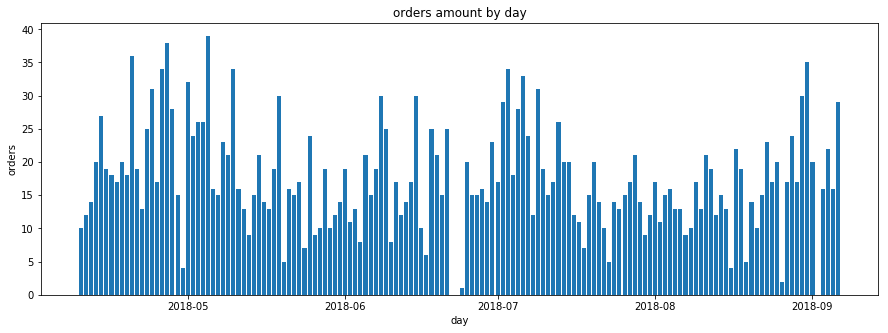

In [18]:
plt.figure(figsize=(15,5))
plt.bar(daily_sum.index, daily_sum.amount)
plt.xlabel('day')
plt.ylabel('orders')
plt.title('orders amount by day')
plt.show()

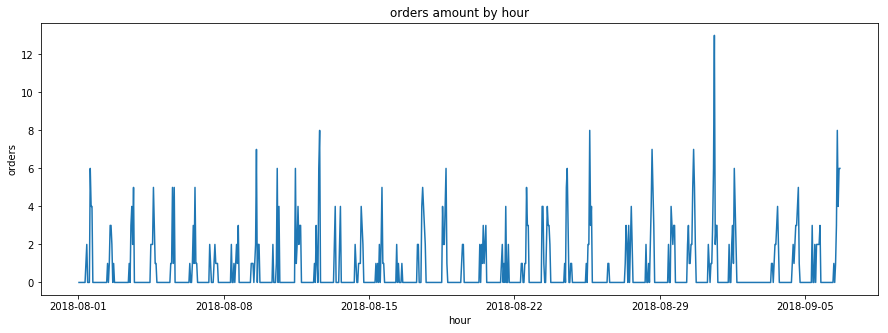

In [19]:
hourly_sum = df.groupby(pd.Grouper(key='timestamp',freq='H')).count()
hourly_sum.rename(columns={'weather':'amount'}, inplace=True)

hourly_sum = hourly_sum[hourly_sum.index > dateutil.parser.parse("2018-08-01")]
plt.figure(figsize=(15,5))
plt.plot(hourly_sum.index, hourly_sum.amount)
plt.xlabel('hour')
plt.ylabel('orders')
plt.title('orders amount by hour')
plt.show()

C:\Users\Simo\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:51: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


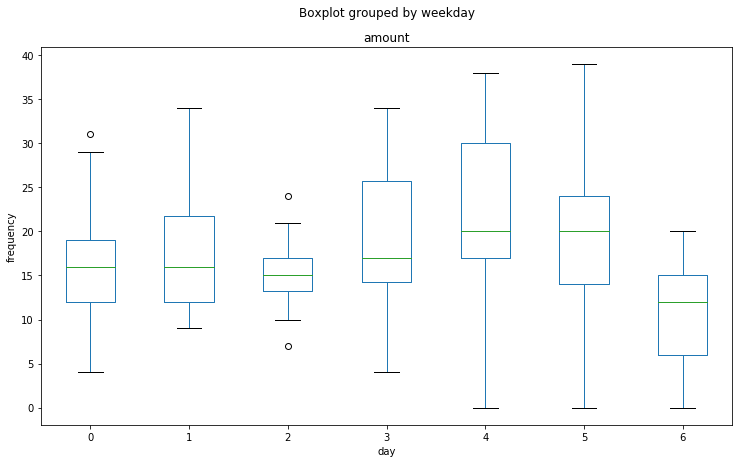

In [20]:
daily_sum['weekday'] = daily_sum.index.weekday
daily_sum.groupby(['weekday']).amount.sum()

daily_sum.boxplot(column='amount', by='weekday', figsize=(12,7), grid=False)
plt.xlabel('day')
plt.ylabel('frequency')
plt.show()

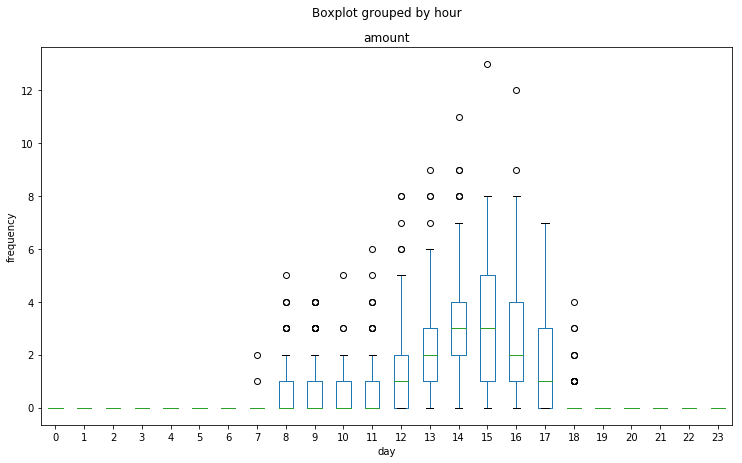

In [21]:
hourly_sum = df.groupby(pd.Grouper(key='timestamp',freq='H')).count()
hourly_sum.rename(columns={'weather':'amount'}, inplace=True)

#add day column to group_by
hourly_sum['hour'] = hourly_sum.index.hour

#application use increases till friday after which it decreases
hourly_sum.groupby(['hour']).amount.sum()


hourly_sum.boxplot(column='amount', by='hour', figsize=(12,7), grid=False)
plt.xlabel('day')
plt.ylabel('frequency')
plt.show()

__Conclusion: Order amounts are  hour and day spesific__

## Checking trends and correlations in consumption

In [22]:
sushi = df.loc[df['sushi'] == 1]
japanese = df.loc[df['japanese'] == 1]
gourmet = df.loc[df['gourmet'] == 1]
fresh = df.loc[df['fresh'] == 1]
fish = df.loc[df['fish'] == 1]

sushi_daily_sum = sushi.groupby(pd.Grouper(key='timestamp',freq='D')).count()
japanese_daily_sum = japanese.groupby(pd.Grouper(key='timestamp',freq='D')).count()
gourmet_daily_sum = gourmet.groupby(pd.Grouper(key='timestamp',freq='D')).count()
fresh_daily_sum = fresh.groupby(pd.Grouper(key='timestamp',freq='D')).count()
fish_daily_sum = fish.groupby(pd.Grouper(key='timestamp',freq='D')).count()


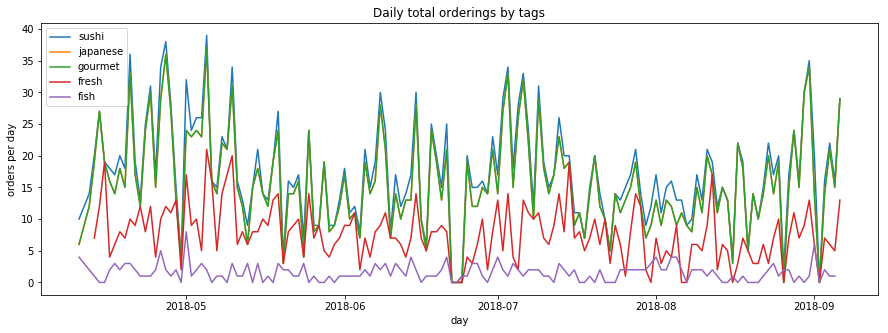

In [23]:
plt.figure(figsize=(15,5))

plt.plot(sushi_daily_sum.index, sushi_daily_sum.weather, label="sushi")
plt.plot(japanese_daily_sum.index, japanese_daily_sum.weather, label="japanese")
plt.plot(gourmet_daily_sum.index, gourmet_daily_sum.weather, label="gourmet")
plt.plot(fresh_daily_sum.index, fresh_daily_sum.weather, label="fresh")
plt.plot(fish_daily_sum.index, fish_daily_sum.weather, label="fish")

plt.legend(loc='upper left')
plt.xlabel('day')
plt.ylabel('orders per day')
plt.title('Daily total orderings by tags')
plt.show()

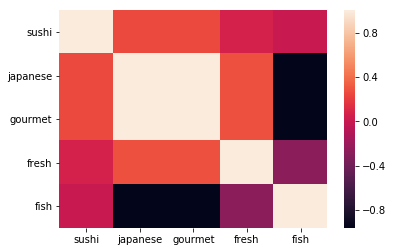

In [25]:
foods = df[['sushi','japanese','gourmet','fresh','fish']]

corr = foods.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)

# Predictions for order amounts

Two models are fitted: __RandomForestRegressor and an traditional SARIMA time-series model__. Performance is compared with MSE  and R2. 

The models are not directly comperable as random forest was trained only to predict hours with no data (7-18), whereas SARIMA-model also considers all the hours in a day.

MSE is used as larger differerences in prediction could be considered worse as opposed to MAE.

R2 is used to understand if the predictions are better than taking the mean

https://otexts.com/fpp2/accuracy.html
https://towardsdatascience.com/how-to-select-the-right-evaluation-metric-for-machine-learning-models-part-1-regrression-metrics-3606e25beae0

##  RandomForestRegressor

(75% of the work was figuring out this model)

This model was done more as an curiosity on how to use scikit-learn to make time-series predictions and to look at how the created model compares to SARIMA-prediction. Randomforest was used as it generally performs well across multiple task
https://machinelearningmastery.com/start-with-gradient-boosting/

Random forest could work well if the non time dependent variables ('weather') have large effect on app usage. 
https://www.quora.com/What-are-some-practical-tricks-tweeks-techniques-for-applying-random-forest-on-time-series-regression

__RandomforestRegressor is used to predict average app usage amounts for future ['weather', 'hour', 'weekday'] pairs based on the averages of past pairs. This averaging process could mimic seasonality found in the data like the SARIMA-model. However the model gives marginal weight to previous day when predicting the next day as opposed to traditional time-series models such as SARIMA.__ 

Week and month are not used in the predictions as there is only a few months of data so they are always unique. 

Another Problem with the model is that it does not handle trend [1], but as we can see from the arima-model trend test below this is not a problem as there exist no trend.

[1] https://stats.stackexchange.com/questions/175908/random-forest-regression-and-trended-time-series

In [92]:
df.head()

timestamp weather  sushi  japanese  gourmet  fresh  fish  \
0 2018-04-10 09:36:53.754   sunny      1         1        1      0     0   
1 2018-04-10 10:27:39.279   sunny      1         0        0      0     1   
2 2018-04-10 10:35:22.101   sunny      1         1        1      0     0   
3 2018-04-10 12:32:17.173   sunny      1         0        0      0     1   
4 2018-04-10 13:13:56.298   sunny      1         1        1      0     0   

   weather_numeric  hour  weekday  week  month  
0                3     9        1    15      4  
1                3    10        1    15      4  
2                3    10        1    15      4  
3                3    12        1    15      4  
4                3    13        1    15      4

In [97]:
df_train = df[df['month'] < 7]
df_test = df[df['month'] >= 7]

display(df_train.shape)
display(df_test.shape)

(1464, 12)

(1143, 12)

In [98]:
df_train_amount = df_train[['weather_numeric', 'hour', 'weekday', 'week', 'month']]
df_test_amount = df_test[['weather_numeric', 'hour', 'weekday', 'week', 'month']]

df_train_amount = df_train_amount.groupby(df_train_amount.columns.tolist()).size().reset_index().\
    rename(columns={0:'amount'})

df_test_amount = df_test_amount.groupby(df_test_amount.columns.tolist()).size().reset_index().\
    rename(columns={0:'amount'})

#reorder again by time for final visualization
df_train_amount = df_train_amount.sort_values(by=['month', 'week','weekday', 'hour'])
df_test_amount = df_test_amount.sort_values(by=['month', 'week','weekday', 'hour'])


display(df_train_amount.head())

display(df_train_amount.shape)
display(df_test_amount.shape)

weather_numeric  hour  weekday  week  month  amount
382                3     9        1    15      4       1
391                3    10        1    15      4       2
416                3    12        1    15      4       1
435                3    13        1    15      4       2
455                3    14        1    15      4       2

(534, 6)

(449, 6)

In [99]:
#week and month not considered as they are alkways unique
X_train = df_train_amount[['weather_numeric', 'hour', 'weekday']]
X_test = df_test_amount[['weather_numeric', 'hour', 'weekday']]

y_train = df_train_amount.amount
y_test = df_test_amount.amount

In [101]:
from sklearn.model_selection import GridSearchCV

grid = {'n_estimators': [20,50,100,200],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [2,3,4,5],
               'min_samples_split': [2,3,4,5],
               'min_samples_leaf': [1,2,4,5]}


#https://stats.stackexchange.com/questions/14099/using-k-fold-cross-validation-for-time-series-model-selection
#https://medium.com/cindicator/backtesting-time-series-models-weekend-of-a-data-scientist-92079cc2c540
#!This would be a wrong approach for gridsearch if the model did not disregard the time-series nature of the data.

rf = RandomForestRegressor(random_state=123)
rf_cv = GridSearchCV(estimator = rf, param_grid = grid, cv = 5,scoring='neg_mean_squared_error',
                     verbose=1, n_jobs = 4)
rf_cv.fit(X_train, y_train)

Fitting 5 folds for each of 512 candidates, totalling 2560 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  62 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 662 tasks      | elapsed:   12.2s
[Parallel(n_jobs=4)]: Done 1662 tasks      | elapsed:   29.0s
[Parallel(n_jobs=4)]: Done 2560 out of 2560 | elapsed:   44.8s finished
C:\Users\Simo\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=123, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'n_estimators': [20, 50, 100, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, 3, 4, 5], 'min_samples_split': [2, 3, 4, 5], 'min_samples_leaf': [1, 2, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=1)

In [102]:
rf_cv.best_params_

{'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 20}

In [103]:
#negative MSE
rf_cv.score(X_train, y_train)

-2.577707245413365

In [104]:
rf = RandomForestRegressor(n_estimators= 20, min_samples_split= 2, 
                           min_samples_leaf=1, max_features='sqrt', max_depth=5, criterion='mse',random_state=123)
rf.fit(X_train, y_train)

display('train r2  %f' % rf.score(X_train, y_train))


mse = mean_absolute_error(rf.predict(X_train), y_train)
display('train MSE: %f' % mse)


display('test (foreast) r2  %f' % rf.score(X_test, y_test))

#mse test (forecast)
mse = mean_squared_error(rf.predict(X_test), y_test)
display('test (forecast)  MSE: %f' % mse)

'train r2  0.323369'

'train MSE: 1.219606'

'test (foreast) r2  0.135709'

'test (forecast)  MSE: 2.508782'

Weathers effect is not large on the model so its addition has probably marginal value to the model

In [31]:
#Most important features
#1. hour
#2. day
#3. weather numeric
print(rf.feature_importances_)

[0.15043291 0.67360148 0.17596561]


__We can see visually that the model produces quite good averages of orders per hour__ 

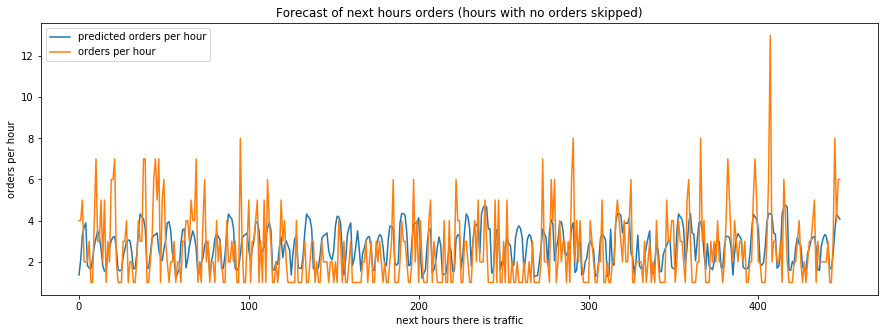

In [32]:
x = rf.predict(X_test)

plt.figure(figsize=(15,5))

plt.plot(np.arange(len(x)), x,label="predicted orders per hour")
plt.plot(np.arange(len(x)), y_test, label="orders per hour")
plt.legend(loc='upper left')
plt.xlabel('next hours there is traffic')
plt.ylabel('orders per hour')
plt.title('Forecast of next hours orders (hours with no orders skipped)')

plt.show()

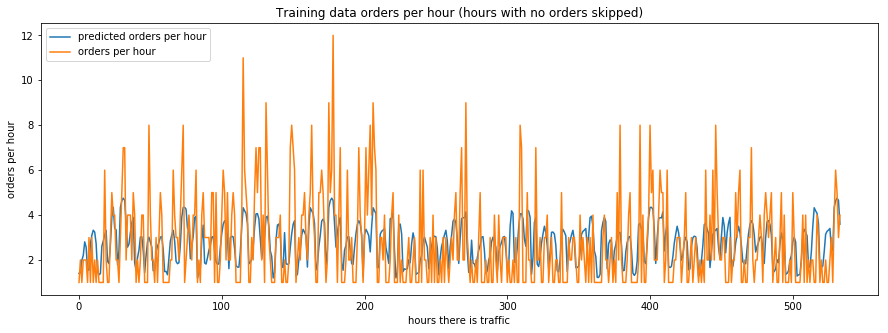

In [33]:
x = rf.predict(X_train)

plt.figure(figsize=(15,5))

plt.plot(np.arange(len(x)), x,label="predicted orders per hour")
plt.plot(np.arange(len(x)), y_train, label="orders per hour")
plt.legend(loc='upper left')
plt.xlabel('hours there is traffic')
plt.ylabel('orders per hour')
plt.title('Training data orders per hour (hours with no orders skipped)')

plt.show()

__Expectedly we get better predictions when we add hours with no orders__

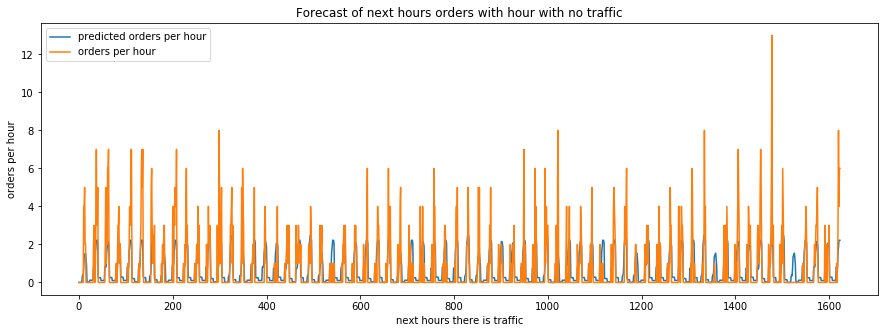

In [87]:
x = rf.predict(X_test)

plt.figure(figsize=(15,5))

plt.plot(np.arange(len(x)), x,label="predicted orders per hour")
plt.plot(np.arange(len(x)), y_test, label="orders per hour")
plt.legend(loc='upper left')
plt.xlabel('next hours')
plt.ylabel('orders per hour')
plt.title('Forecast of next hours orders with hours with no traffic')

plt.show()

## SARIMA time-series model

SARIMA = ARIMA time-series model with Seasonality

The method approximately used in fitting SARIMA model:
https://en.wikipedia.org/wiki/Box%E2%80%93Jenkins_method

In [113]:
hourly_sum = df.groupby(pd.Grouper(key='timestamp',freq='H')).count()
hourly_sum.rename(columns={'weather':'amount'}, inplace=True)
hourly_sum = hourly_sum[['amount']]

In [114]:
arimax_train = hourly_sum[hourly_sum.index < dateutil.parser.parse("2018-07-01")]
arimax_test = hourly_sum[hourly_sum.index > dateutil.parser.parse("2018-07-01")]

display(arimax_train.shape)
display(arimax_test.shape)

(1959, 1)

(1624, 1)

__Checck the time-series for stationarity__

p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [109]:
res = sm.tsa.adfuller(arimax_train.amount,regression='ct')
display('ct: p-value:{}'.format(res[1]))

res = sm.tsa.adfuller(arimax_train.amount,regression='c')
display('c: p-value:{}'.format(res[1]))


'ct: p-value:1.1571040999713766e-05'

'c: p-value:2.4244417786024292e-05'

__Checck the time-series for seasonality__

Clear 24 hour seasonal component as shown from the decomposition and autocorrelation functions

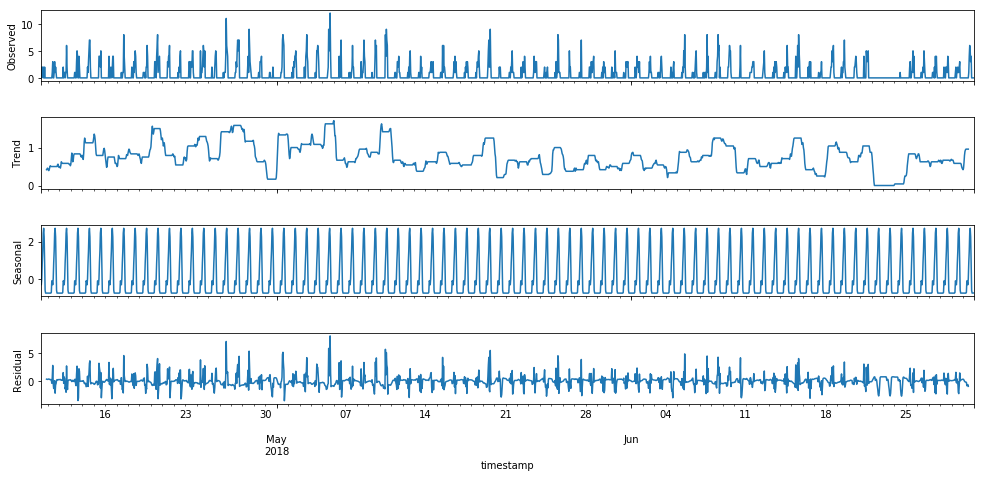

In [115]:
decomposition = sm.tsa.seasonal_decompose(arimax_train.amount)
resplot = decomposition.plot()
resplot.set_figheight(8)
resplot.set_figwidth(15)

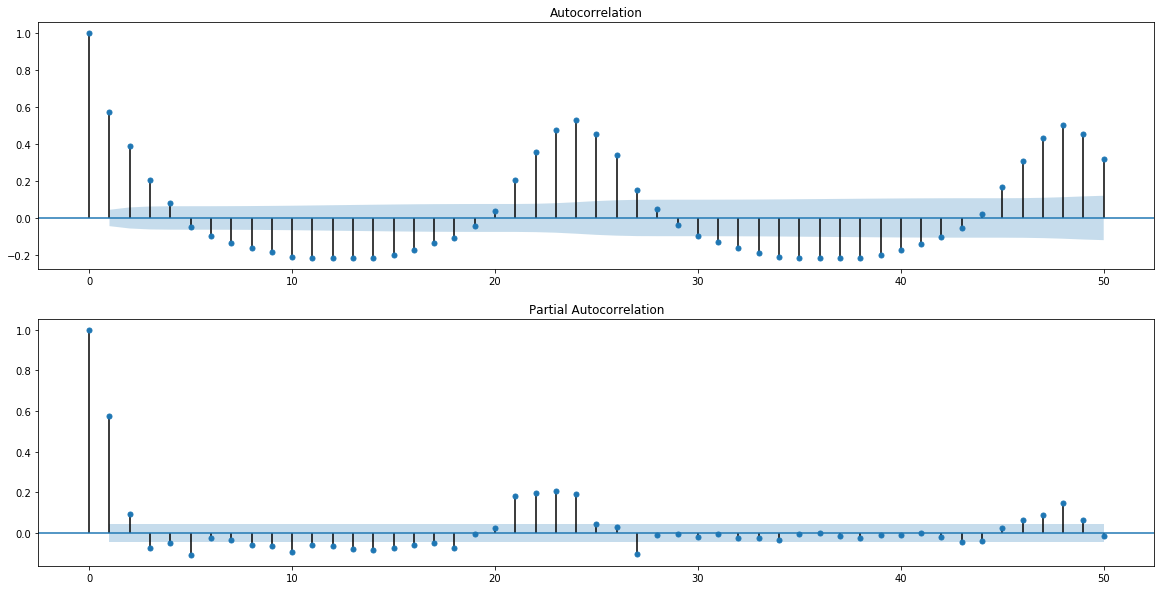

In [39]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(arimax_train.amount, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(arimax_train.amount, lags=50, ax=ax[1])
plt.show()

__best arimax model parameters with auto arima__

Best model: SARIMAX(2, 1, 1)x(0, 1, 2, 24)

In [67]:
stepwise_fit = pm.auto_arima(arimax_train.amount, start_p=1, start_q=1, max_p=3, max_q=3, m=24,
                            seasonal=True, d=1, D=1, trace=True,
                            error_action='ignore',  # don't want to know if an order does not work
                            suppress_warnings=True,  # don't want convergence warnings
                            stepwise=True)  # set to stepwise
stepwise_fit.summary()

Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 24); AIC=5953.147, BIC=5986.551, Fit time=74.799 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 24); AIC=8001.628, BIC=8012.762, Fit time=0.664 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 24); AIC=7090.554, BIC=7112.824, Fit time=7.201 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 24); AIC=6076.441, BIC=6098.711, Fit time=58.564 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 24); AIC=5958.905, BIC=5986.741, Fit time=88.503 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 1, 24); AIC=5968.001, BIC=6006.972, Fit time=186.318 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 24); AIC=6559.545, BIC=6587.382, Fit time=64.269 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 24); AIC=5956.940, BIC=5995.911, Fit time=218.733 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 24); AIC=7058.881, BIC=7081.151, Fit time=21.335 seconds
Fit ARIMA: order=(1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1959
Model:             SARIMAX(2, 1, 1)x(0, 1, 2, 24)   Log Likelihood               -2965.557
Date:                            Thu, 07 Mar 2019   AIC                           5945.113
Time:                                    00:37:02   BIC                           5984.084
Sample:                                         0   HQIC                          5959.447
                                           - 1959                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -9.977e-06   1.65e-05     -0.605      0.545   -4.23e-05    2.23e-05
ar.L1          0.2380      0.014     16.906      0.000       0.210       0.266
ar.L2          0.0858      0.015      5.600      0.000       0.056       0.116
ma.L1         -0.9900      0.006   -174.320      0.000      -1.001      -0.979
ma.S.L24      -0.9454      0.057    -16.614      0.000      -1.057      -0.834
ma.S.L48      -0.0516      0.015     -3.366      0.001      -0.082      -0.022
sigma2         1.1780      0.070     16.942      0.000       1.042       1.314
===================================================================================
Ljung-Box (Q):                       51.84   Jarque-Bera (JB):              5591.18
Prob(Q):                              0.10   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                             1.16
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [62]:
sarima = sm.tsa.statespace.SARIMAX(arimax_train.amount,order=(2,1,1),seasonal_order=(0,1,2,24),
                                 enforce_stationarity=False, enforce_invertibility=False).fit()

sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                             amount   No. Observations:                 1959
Model:             SARIMAX(2, 1, 1)x(0, 1, 2, 24)   Log Likelihood               -2884.457
Date:                            Wed, 06 Mar 2019   AIC                           5780.914
Time:                                    23:47:45   BIC                           5814.160
Sample:                                04-10-2018   HQIC                          5793.158
                                     - 06-30-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2395      0.014     17.182      0.000       0.212       0.267
ar.L2          0.0817      0.015      5.364      0.000       0.052       0.112
ma.L1         -1.0037      0.004   -255.824      0.000      -1.011      -0.996
ma.S.L24      -0.9354      0.014    -65.484      0.000      -0.963      -0.907
ma.S.L48      -0.0416      0.014     -3.027      0.002      -0.069      -0.015
sigma2         1.2009      0.021     58.408      0.000       1.161       1.241
===================================================================================
Ljung-Box (Q):                       43.65   Jarque-Bera (JB):              5289.68
Prob(Q):                              0.32   Prob(JB):                         0.00
Heteroskedasticity (H):               0.62   Skew:                             1.05
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

__Visualize the prediction__

In [70]:
pred = sarima.predict(1959 + 1,1959 + 1624)

SARIMA model MSE:1.1734172536255787
SARIMA model R2:0.44092436302112137


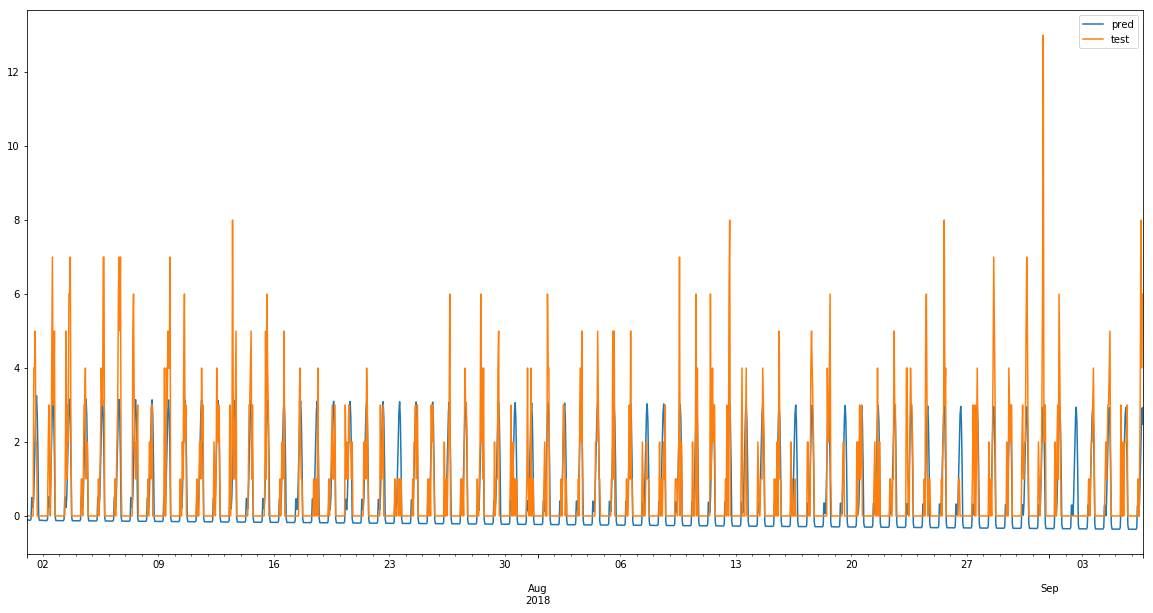

In [90]:
print('SARIMA model MSE:{}'.format(mean_squared_error(arimax_test,pred)))
print('SARIMA model R2:{}'.format(r2_score(arimax_test,pred)))

pd.DataFrame({'test':arimax_test.values.flatten(),'pred':pred}).plot(figsize=(20,10));plt.show()

__By removing the hours, which there is no data of we can better compare the two models, expectedly the performance decreases__


In [72]:
pred_hours_remove = pred.between_time('08:00:00', '18:00:00')
arimax_test_hours_remove = arimax_test.between_time('08:00:00', '18:00:00')

SARIMA model MSE:2.4821556591008487
SARIMA model R2:0.24780958317918567


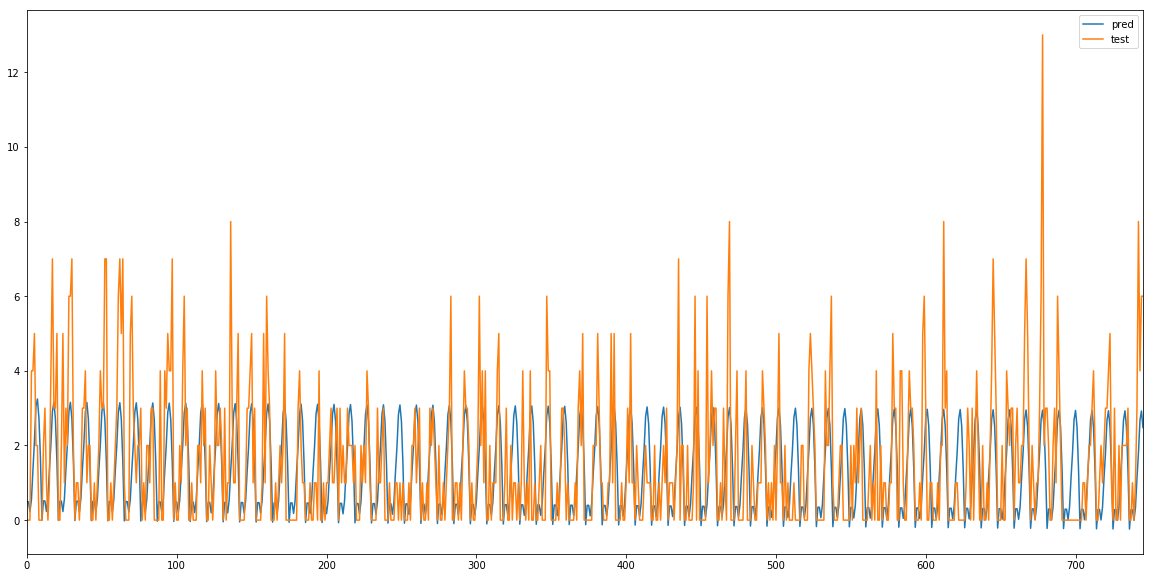

In [89]:
print('SARIMA model MSE:{}'.format(mean_squared_error(arimax_test_hours_remove,pred_hours_remove)))
print('SARIMA model R2:{}'.format(r2_score(arimax_test_hours_remove,pred_hours_remove)))

pd.DataFrame({'test':arimax_test_hours_remove.values.flatten(),'pred':pred_hours_remove.values.flatten()}).plot(figsize=(20,10))
plt.show()

# Conclusions of prediction

__Comparison on hours with app usage > 0 (7-18):__

SARIMA:

ARIMAX model MSE:2.4821556591008487

ARIMAX model R2:0.24780958317918567

RF:

'test (foreast) r2  0.135709'

'test (forecast)  MSE: 2.508782'

Expectedly SARIMA time-series model worked better for the data as it was able to best model the seasonal and time dependece on prior components of the time-series. The models accuracy could be increased by adding exogenous variables to the model such as weather (SARIMAX-model). Then if we had weather forecast for the next day we could enhance the days prediction. It would also help to have data from a larger period time to better model seasonality [1]. 

[1] https://www.researchgate.net/post/What_should_be_the_minimum_number_of_observations_for_a_time_series_model

## For future analysis

For future analysis it would be nice to have data from different cities and larger amount of venue tags as this could provide important information about other cities consumption trends. This probably would also make the distance column more useful as different cities have different average distance to the restaurant. It would also be nice to have some kind of number of restaurants using the app in the area to gauge the ratio of orders / restaurants. 

In general it would be nice to have data from a longer period as trends do not often emerge themself's in a few months and it would make the predictions more accurate.  

Exogenous variables such as weather that can be used to improve to time-series forcasting method could be added. 
For example if we plan to schedule a campaign on some future days and the same type of campaign has had an spesific type of inpact on food orderings in the past. This past information can be added to the model to better predict inpact on food orderings.

Theres could also be an preprocessed data source with some key predictive features per hour for each city to make the predictive model building easier and more consistent. Less data wrangling more modeling. 